In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import skimage

import scipy.stats as st
from scipy.signal import find_peaks, peak_widths

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.graphics.mosaicplot import mosaic
from pathlib import Path

In [3]:
RANDOM_STATE = 26

# Metro in Portugal

## 1. Data

### Description

The second data set contains real data of the metro trains in Porto, Portugal. Data is recorded in the period Jan-Jun 2022.

The dataset (1.7 GB) can be downloaded from [here](https://zenodo.org/record/6854240#.YvuPmHZBzBV) ([direct link](https://zenodo.org/record/6854240/files/dataset_train.csv?download=1)). Sections of the [paper](https://arxiv.org/abs/2207.05466) ([pdf](https://arxiv.org/pdf/2207.05466.pdf#view=fitH&toolbar=1)) are quoted below to understand the context:

>The Air Production Unit (APU) installed on the roof of Metro vehicles feeds units that perform different functions. One of these units is the secondary suspension, responsible for maintaining the height of the vehicle level regardless of the onboard number of passengers. 

> ...analog sensor signals (pressure, temperature, current consumption), digital signals (control signals, discrete signals), and GPS information (latitude, longitude, and speed).

>The main goal of the MetroPT dataset is to become a benchmark dataset for Predictive Maintenance. That is a real-world dataset, where the ground truth of anomalies is known from the company’s maintenance reports.

**Disclaimer**: It took my computer ~ 40 seconds to load the data. This was the cell that took the longest. Even though I experimented with several methods how to handle large data (reading pandas chunks, reading using dask, splitting into several csv files), in the end I decided that the standard way is easier and more practical.

### Paths

In [15]:
DESKTOP = Path().home() / "Desktop"
INPUT_DATA = DESKTOP / "data/dataset_train.csv"
META_DATA = "data/metro_meta_data.xlsx"

### Schematic

Hydro-pneumatic schmatic of the Air Production Unit (APU) taken from the article pdf.

<img src="images/2022-08-26 15_07_17.png">

### Columns

All original columns are listed below, a brief description is also added. This information is stored in an external excel file containing all meta data.

There are 3 types of data: 
- analogue (e.g. pressure)
- digital (e.g. valve activation flag)
- GPS

In [5]:
features_meta_data = pd.read_excel(META_DATA, sheet_name = "features")
features_meta_data[["original_name", "variable_type", "description_short"]]

,original_name,variable_type,description_short
0,timestamp,na,timestamp
1,TP2,analogue,compressor pressure
2,TP3,analogue,pneumatic panel pressure
3,H1,analogue,H1 valve activation
4,DV_pressure,analogue,pressure drop when towers discharge water
5,Reservoirs,analogue,unknown
6,Oil_temperature,analogue,temperature of the compressor oil
7,Flowmeter,analogue,unknown
8,Motor_current,analogue,motor current
9,COMP,digital,compressor air intake valve


### Failures

3 catastrophic failures were recorded during the 6 months of monitoring.

In [6]:
reported_failures = pd.read_excel(META_DATA, sheet_name = "failures")
reported_failures

,id,failure_type,component,start,end
0,1,Air Leak,Air Dryer,2022-02-28 21:53:00,2022-03-01 02:00:00
1,2,Air Leak,Clients,2022-03-23 14:54:00,2022-03-23 15:24:00
2,3,Oil Leak,Compressor,2022-05-30 12:00:00,2022-06-02 06:18:00


## 2. Clean and tidy

### Read

In [7]:
metro = pd.read_csv(INPUT_DATA)

### Get to know

In [8]:
metro.head(2)

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,...,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsLong,gpsLat,gpsSpeed,gpsQuality
0,2022-01-01 06:00:00,-0.012,9.758,9.76,-0.028,1.576,63.35,19.049625,3.9550,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1
1,2022-01-01 06:00:01,-0.012,9.760,9.76,-0.028,1.578,63.25,19.049625,4.0275,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1


In [9]:
metro.shape

(10979546, 21)

In [10]:
metro.columns

Index(['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality'],
      dtype='object')

In [11]:
metro.dtypes

timestamp           object
TP2                float64
TP3                float64
H1                 float64
DV_pressure        float64
Reservoirs         float64
Oil_temperature    float64
Flowmeter          float64
Motor_current      float64
COMP                 int64
DV_eletric           int64
Towers               int64
MPG                  int64
LPS                  int64
Pressure_switch      int64
Oil_level            int64
Caudal_impulses      int64
gpsLong            float64
gpsLat             float64
gpsSpeed             int64
gpsQuality           int64
dtype: object

### Check for missing values

No values are missing.

In [12]:
metro.isna().sum()

timestamp          0
TP2                0
TP3                0
H1                 0
DV_pressure        0
Reservoirs         0
Oil_temperature    0
Flowmeter          0
Motor_current      0
COMP               0
DV_eletric         0
Towers             0
MPG                0
LPS                0
Pressure_switch    0
Oil_level          0
Caudal_impulses    0
gpsLong            0
gpsLat             0
gpsSpeed           0
gpsQuality         0
dtype: int64

### Select columns

2 columns are removed because their meaning is unknown.

In [16]:
print("Dropped columns: ", features_meta_data[features_meta_data.keep == "no"].original_name.to_list())
print("Selected columns: ", features_meta_data[features_meta_data.keep == "yes"].original_name.to_list())

Dropped columns:  ['Pressure_switch', 'Caudal_impulses']
Selected columns:  ['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Oil_level', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']


In [14]:
columns_to_keep = features_meta_data[features_meta_data.keep == "yes"].original_name
metro = metro[columns_to_keep]

### Rename columns

New names for the remaining columns are loaded from the excel meta data file.

In [18]:
features_meta_data[features_meta_data.keep == "yes"][["original_name", "new_name"]]

,original_name,new_name
0,timestamp,timestamp
1,TP2,compressor_pressure
2,TP3,pneumatic_pressure
3,H1,h1_valve
4,DV_pressure,dv_pressure
5,Reservoirs,reservoirs
6,Oil_temperature,oil_temperature
7,Flowmeter,flow
8,Motor_current,motor_current
9,COMP,compressor_intake_valve


In [19]:
new_names = features_meta_data[features_meta_data.keep == "yes"].new_name
new_names.name = ""
metro.columns = new_names

### Set index

In [20]:
metro.timestamp = pd.to_datetime(metro.timestamp)
metro = metro.set_index("timestamp")

In [22]:
start, end = metro.index[0], metro.index[-1]
print(f"Data is recorded in the period: {start} to {end}")

Data is recorded in the period: 2022-01-01 06:00:00 to 2022-06-02 15:49:53


## 3. Explore

### Create columns groups

Divide the columns in groups for easier filtering during EDA:
- `analogue_columns` = signal is continuous
- `digital_columns` = 1 or 0
- `gps_columns` = spatial data

In [30]:
used_columns = features_meta_data[features_meta_data.keep == "yes"]
columns_by_type = used_columns.groupby("variable_type")

analogue_columns = columns_by_type.get_group("analogue").new_name
digital_columns = columns_by_type.get_group("digital").new_name
gps_columns = columns_by_type.get_group("gps data").new_name
non_gps_columns = pd.concat([analogue_columns, digital_columns])

names = ["Analogue", "Digital", "GPS", "Non-GPS"]
groups = [analogue_columns, digital_columns, gps_columns, non_gps_columns]
for name, group in zip(names, groups):
    print(f"{name}: {group.values}\n")

Analogue: ['compressor_pressure' 'pneumatic_pressure' 'h1_valve' 'dv_pressure'
 'reservoirs' 'oil_temperature' 'flow' 'motor_current']

Digital: ['compressor_intake_valve' 'compressor_outlet_valve' 'tower' 'mpg' 'lps'
 'oil_level']

GPS: ['lon' 'lat' 'speed' 'quality']

Non-GPS: ['compressor_pressure' 'pneumatic_pressure' 'h1_valve' 'dv_pressure'
 'reservoirs' 'oil_temperature' 'flow' 'motor_current'
 'compressor_intake_valve' 'compressor_outlet_valve' 'tower' 'mpg' 'lps'
 'oil_level']



### Time series

#### Single day

In [55]:
def plot_timeseries_in_sequence(df, suptitle="", width=6, height=3):
    """
    Plot all columns of `df` below each other.
    `df` - df where each column is a time series
    `title` - plot title
    `width` and `height` - the dimensions of a single plot
    """
    n_plots = len(df.columns)
    fig, axs = plt.subplots(n_plots, figsize = (width, height * n_plots), sharex=True)
    
    for column, ax in zip(df.columns, axs):
        ax.plot(df[column])
        ax.set_ylabel(column)
        ax.set_title(f"Timeseries for {column}")
    
    axs[-1].set_xlabel("Time")
    fig.suptitle(suptitle, fontsize = 24, verticalalignment = "baseline")
    plt.show()   

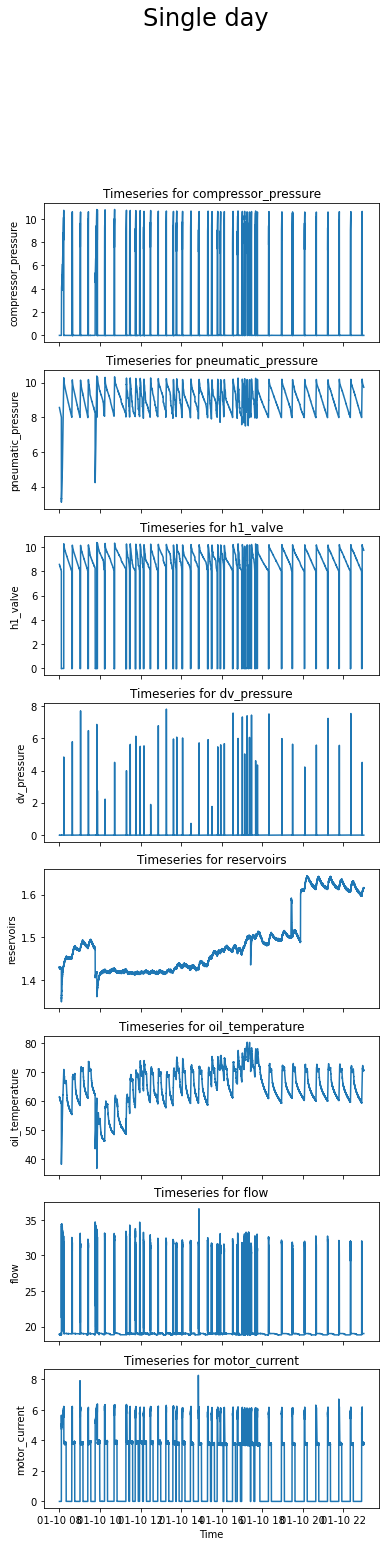

In [54]:
plot_timeseries_in_sequence(metro_single_day[analogue_columns], "Single day")

In [19]:
def plot_multiple_columns(df, columns, title=""):
    n_plots = len(columns)
    fig, axs = plt.subplots(n_plots, figsize = (12, 3 * n_plots), sharex=True)
    for i, col in enumerate(cols):
        axs[i].plot(df[col])
        axs[i].set_ylabel(col)
        axs[i].set_title(col)
    axs[-1].set_xlabel("Time")
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [33]:
single_day = "('2022-01-10 08:00' < timestamp) & (timestamp < '2022-01-10 23:00')"
metro_single_day = metro.query(single_day)[analogue_columns]

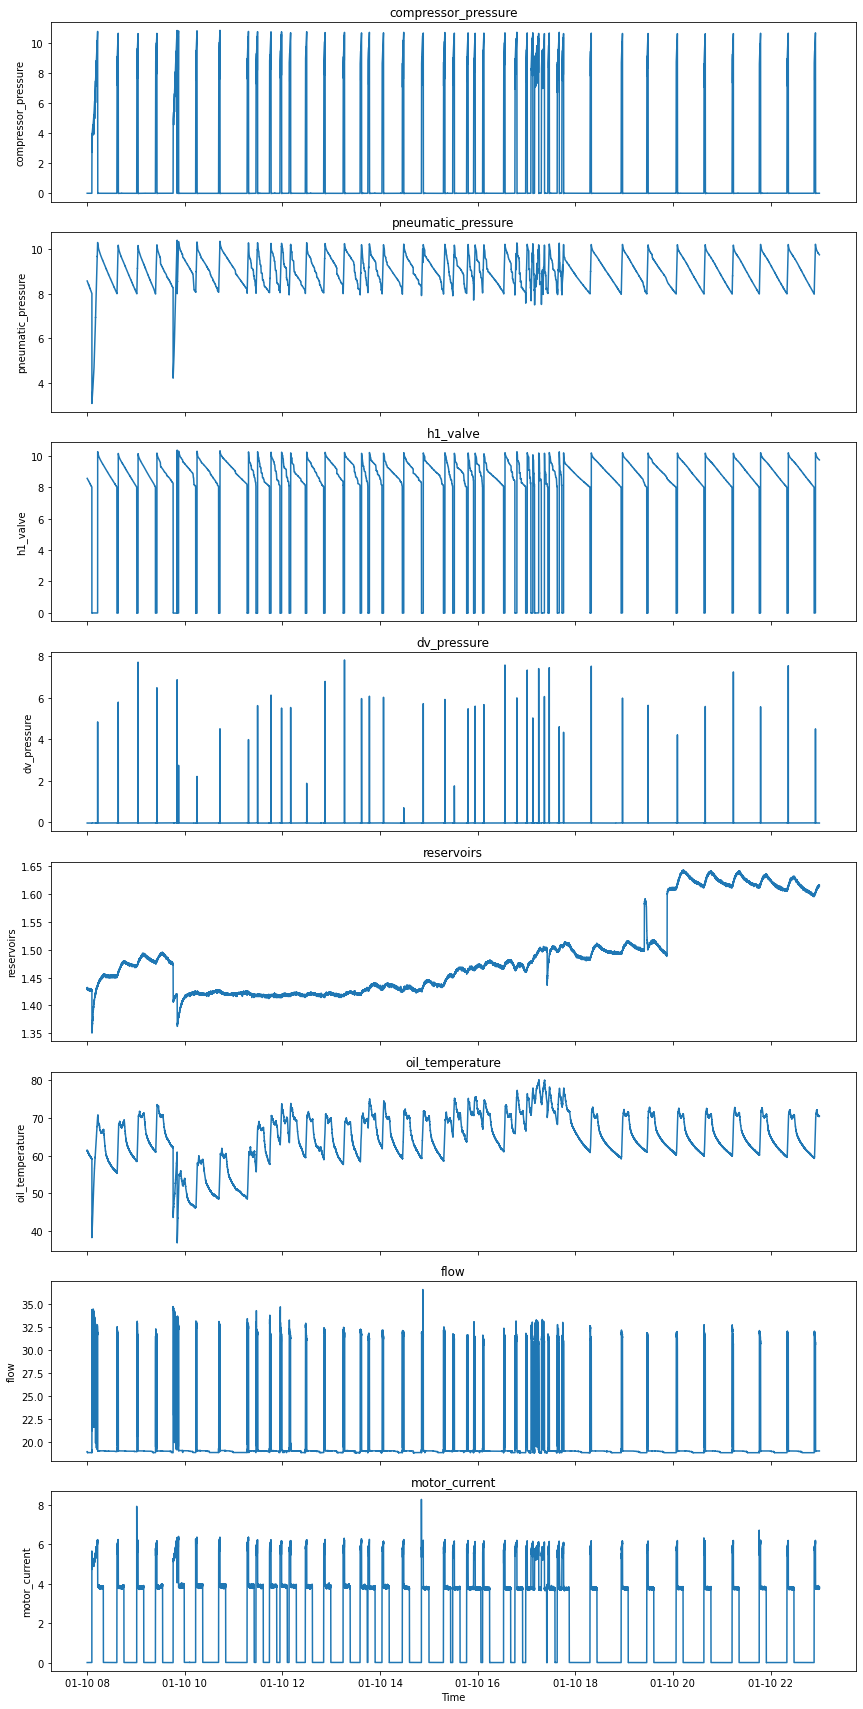

In [20]:
single_day = "('2022-01-10 08:00' < timestamp) & (timestamp < '2022-01-10 23:00')"
plot_multiple_columns(metro.query(single_day), analogue_columns)

#### Single day morning

In [21]:
morning = "('2022-01-10 08:00' < timestamp) & (timestamp < '2022-01-10 10:00')"
plot_multiple_columns(metro_smooth_analogue.query(morning), analogue_columns)

NameError: name 'metro_smooth_analogue' is not defined

In [ ]:
morning = "('2022-01-10 08:00' < timestamp) & (timestamp < '2022-01-10 10:00')"
plot_multiple_columns(metro.query(morning), analogue_columns)

#### First failure

In [ ]:
# Info
reported_failures[reported_failures.id == 1]

In [ ]:
failure_interval = "('2022-02-28 21:00' <= timestamp) & (timestamp <= '2022-03-01 03:00')"
first_failure = metro.query(failure_interval)

plot_multiple_columns(first_failure, analogue_columns)

#### Second failure

In [ ]:
# Info
reported_failures[reported_failures.id == 2]

In [ ]:
failure_interval = "('2022-03-23 14:00' <= timestamp) & (timestamp <= '2022-03-23 16:00')"
second_failure = metro.query(failure_interval)

plot_multiple_columns(second_failure, analogue_columns)

#### Third failure

In [ ]:
# Info
reported_failures[reported_failures.id == 3]

In [ ]:
failure_interval = "('2022-05-30 11:00' <= timestamp) & (timestamp <= '2022-06-02 07:00')"
third_failure = metro.query(failure_interval)

plot_multiple_columns(third_failure, analogue_columns)

In [ ]:
failure_interval = "('2022-06-02 01:00' <= timestamp) & (timestamp <= '2022-06-02 07:00')"
third_failure_2 = metro.query(failure_interval)

plot_multiple_columns(third_failure_2, analogue_columns)

### Geographic data

#### Train speed

In [ ]:
metro[gps_columns].head(2)

In [ ]:
start = "2022-01-10 08:00"
end = "2022-01-10 12:00"
query = f"('{start}' <= timestamp) & (timestamp <= '{end}') & (quality == 1)"
gps_data = metro[gps_columns].query(query)

In [ ]:
# fig = px.scatter_mapbox(
#     gps_data, 
#     lat="lat", 
#     lon="lon", 
#     color = "speed", 
#     # zoom=10, 
#     title=f"Metro route and speed from {start} to {end}",
# )

# fig.update_layout(mapbox_style="carto-positron")
# fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
# fig.show()

#### Stations

In [ ]:
stations = pd.read_excel(META_DATA, sheet_name = "stations")
stations

#### Train speed and stations

Observations:
- Low train speed indicates a station. The stations match with the indication.

In [ ]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scattermapbox(
#         lat=gps_data.lat,
#         lon=gps_data.lon,
#         marker = go.scattermapbox.Marker(color = gps_data.speed),
#         name = "Train speed",
#     )
# )

# fig.add_trace(
#     go.Scattermapbox(
#         lat=stations.lat,
#         lon=stations.lon,
#         mode='markers',
#         marker=go.scattermapbox.Marker(
#             size=16,
#             color='green',
#             opacity=0.6,
#             ),
#         text=stations.station,
#         name = "Stations",
#     )
# )

# fig.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":30,"l":0,"b":0},
#     title="Train speed and stations",
# )
# fig.show()

#### Failure locations

Select narrower failure intervals based on the abnormalities in sensor readings observed in above analyses.

Also filter out the invalid gps readings (`[metro.quality == 1]`).

The third failure is omitted since:
- there is no valid GPS data in the failure period
- the time of occurrence can't be determined as the reported duration is much longer than the other two (2 days vs 1-2 hours)

In [ ]:
interval = "('2022-02-28 22:00' <= timestamp) & (timestamp <= '2022-03-01 01:00')"
first_breakdown = metro[metro.quality == 1].query(interval)

interval = "('2022-03-23 14:54' <= timestamp) & (timestamp <= '2022-03-23 15:24')"
second_breakdown = metro[metro.quality == 1].query(interval)

for breakdown in [first_breakdown, second_breakdown]:
    print(breakdown.shape)

In [ ]:
# fig = go.Figure()

# # Failures
# for breakdown, label in zip([first_breakdown, second_breakdown], ['First failure', 'Second failure']):
#     fig.add_trace(
#         go.Scattermapbox(
#             lat=breakdown.lat,
#             lon=breakdown.lon,
#             opacity=0.5,
#             marker={"size": 5,},
#             name=label,
#         )
#     )

# # Stations
# fig.add_trace(
#     go.Scattermapbox(
#         lat=stations.lat,
#         lon=stations.lon,
#         marker={
#             "size": 15,
#         },
#         text = stations.station,
#         name = "Stations"
#     )
# )

# fig.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":30,"l":0,"b":0},
#     title="Failure and station locations"
# )
# fig.show()

#### GPS data quality

In [ ]:
interval = "('2022-02-10 01:00' <= timestamp) & (timestamp <= '2022-06-02 06:00')"
quality_third_failure = metro.query(interval).quality

In [ ]:
plt.plot(quality_third_failure)
plt.show()

# TODO: threshold by frequency to remove noise

### Signal peaks 

#### One variable

Steps:
1. Filter data for a short period and with proper GPS quality.
2. Select one analogue sensor signal. Find its peaks.
3. Plot to validate result.

`compressor_pressure` is chosen as signal because its shape seems suitable.

In [ ]:
start = "2022-01-10 08:00"
end = "2022-01-10 12:00"
one_hour = f"('{start}' <= timestamp) & (timestamp <= '{end}') & (quality == 1)"
metro_one_hour = metro.query(one_hour)

In [ ]:
signal = metro_one_hour.compressor_pressure
peak_indeces, _ = find_peaks(signal, height=10, distance=300)
peaks = signal.iloc[peak_indeces].copy()

In [ ]:
print(f"Peaks count: {len(peaks)}")

plt.figure(figsize = (12, 4))
plt.plot(signal)
plt.plot(peaks, "rx")
plt.show()

In [ ]:
# fig1 = px.line(signal)
# fig2 = px.scatter(peaks, color_discrete_sequence=['#ff7f0e'])
# fig3 = go.Figure(data=fig1.data + fig2.data)
# fig3.show()

### Compare peeks to stations

In [ ]:
peaks_gps_data = metro_one_hour[metro_one_hour.index.isin(peaks.index)][["lon", "lat"]]

stations_and_peaks = pd.concat([stations, peaks_gps_data], keys=["station", "peak"])
stations_and_peaks = stations_and_peaks.reset_index()
stations_and_peaks = stations_and_peaks.drop(columns=["level_1"])
stations_and_peaks = stations_and_peaks.rename(columns={"level_0": "location_type"})

stations_and_peaks

In [ ]:
# fig = px.scatter_mapbox(
#     data_frame = stations_and_peaks,
#     lat="lat",
#     lon="lon",
#     color="location_type",
# )

# fig.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":30,"l":0,"b":0},
#     title="Peeks and stations"
# )
# fig.show()

In [ ]:
# fig = go.Figure()

# # Sensor peaks
# fig.add_trace(
#     go.Scattermapbox(
#         lat=peaks_gps_data.lat,
#         lon=peaks_gps_data.lon,
#         name = "Compressor pressure peaks",
#     )
# )

# # Stations
# fig.add_trace(
#     go.Scattermapbox(
#         lat=stations.lat,
#         lon=stations.lon,
#         mode="markers",
#         marker={
#             "size": 15,
#         },
#         text = stations.station,
#         name = "Stations"
#     )  
# )

# fig.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":30,"l":0,"b":0},
#     title="Failure and station locations"
# )
# fig.show()

### Plot widths
`peak_widths` returns a `tuple(width, y, x_start, x_end)`

In [ ]:
widths = peak_widths(x, peaks, rel_height=0.95)
widths 

In [ ]:
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(y = widths[1], xmin = widths[2], xmax = widths[3], color="red")
plt.xlim((1000, 1500))
plt.show()

In [ ]:
fig1 = px.line(x)
fig2 = px.scatter(x = peaks, y = x[peaks], color_discrete_sequence=['#ff7f0e'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

In [ ]:
plt.plot(metro.Reservoirs)
plt.show()

### Smoothing

In [ ]:
first_failure

In [ ]:
first_failure.compressor_pressure.ewm(span = 60).mean()

In [ ]:
plt.plot(first_failure.compressor_pressure)
plt.plot(first_failure.compressor_pressure.ewm(span = 60).mean())
plt.show()

## Future work

The authors themselves ([paper](https://arxiv.org/pdf/2207.05466)) identify two primary purposes of the dataset:
1) Predicting failures (the start and the duration). Goal: minimize the number of false positives and false negatives. Requirement by the metro company: detect the failure at least two hours before the train becomes non-operational.
2) Identifying the components involved in the failure.


Ideas how to continue the analysis:
- Create a new column with the type of the location: "during traveling" or when "at station". Do this by checking if a set of coordinates is inside the station vicinity (e.g. a circle with specific radius).
- Compare data for the same location (e.g. station) but in different days.
- Smooth the data.
- Model the data (and make predictions?).